# Stablecoin Health Monitor

### 1. Fetching Stablecoin Data from CoinGecko (using Pro API Key) and saving it on a joblib file

In [2]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv
# Load your API key from .env file
load_dotenv()
COINGECKO_PRO_API_KEY = os.getenv("COINGECKO_PRO_API_KEY")

# Set up API endpoint and parameters
url = "https://pro-api.coingecko.com/api/v3/coins/markets"
params = {
    "vs_currency": "usd",
    "category": "stablecoins",
    "order": "market_cap_desc",
    "per_page": 50,
    "page": 1,
    "sparkline": False
}
headers = {
    "x-cg-pro-api-key": COINGECKO_PRO_API_KEY
}

# Make the request
response = requests.get(url, params=params, headers=headers)
data = response.json()

# Convert to DataFrame
df = pd.DataFrame(data)
df.head()

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
0,tether,usdt,Tether,https://coin-images.coingecko.com/coins/images...,1.000000,168040176834,3,168040176834,8.220988e+10,1.000000,...,1.680279e+11,NaN,1.320,-24.41193,2018-07-24T00:00:00.000Z,0.572521,74.68393,2015-03-02T00:00:00.000Z,None,2025-09-02T12:48:21.843Z
1,usd-coin,usdc,USDC,https://coin-images.coingecko.com/coins/images...,0.999815,71760347900,7,71761898928,8.184136e+09,0.999908,...,7.177396e+10,NaN,1.170,-14.75079,2019-05-08T00:40:28.300Z,0.877647,13.90949,2023-03-11T08:02:13.981Z,None,2025-09-02T12:48:23.120Z
2,ethena-usde,usde,Ethena USDe,https://coin-images.coingecko.com/coins/images...,0.999062,12436634009,16,12441217953,1.793332e+08,1.005000,...,1.243965e+10,NaN,1.032,-3.12410,2023-12-20T15:38:34.596Z,0.929486,7.56900,2024-10-04T07:57:15.809Z,None,2025-09-02T12:48:26.146Z
3,usds,usds,USDS,https://coin-images.coingecko.com/coins/images...,0.999681,8115213763,29,8115213763,3.767365e+06,1.000000,...,8.117842e+09,NaN,1.057,-5.45388,2024-10-29T05:40:51.197Z,0.948265,5.41958,2024-10-03T13:19:28.826Z,None,2025-09-02T12:48:21.702Z
4,dai,dai,Dai,https://coin-images.coingecko.com/coins/images...,0.998721,4606941658,42,4607336772,1.103901e+08,1.001000,...,4.614225e+09,NaN,1.220,-18.01221,2020-03-13T03:02:50.373Z,0.881960,13.31289,2023-03-11T07:50:50.514Z,None,2025-09-02T12:48:25.608Z


In [3]:
df['symbol'].value_counts().sum()
df.shape

(50, 26)

In [4]:
import joblib

# Save raw data (list of dicts) to a joblib file
joblib.dump(data, "../data/stablecoins_raw.joblib")

['../data/stablecoins_raw.joblib']

2. Fetching global market data to get stablecoin dominance

In [6]:
# Usdt and usdc alone

# Fetch global market data from CoinGecko
global_url = "https://pro-api.coingecko.com/api/v3/global"
global_response = requests.get(global_url, headers=headers)
global_data = global_response.json()

market_caps = global_data['data']['market_cap_percentage']
stablecoin_dominance = market_caps.get('usdt', 0) + market_caps.get('usdc', 0)
print("Total Stablecoin Dominance (%) of USDT and USDC alone:", stablecoin_dominance, "%")

Total Stablecoin Dominance (%) of USDT and USDC alone: 6.246818432121087 %


In [7]:
# Calculate individual dominance for all major stablecoins using /coins/markets data
# Get total market cap from global data
total_market_cap = global_data['data']['total_market_cap']['usd']

# List of major stablecoins (update as needed)
stablecoins = ['usdt', 'usdc', 'dai', 'busd', 'tusd', 'gusd', 'frax', 'eurt', 'alusd']

# Use the original CoinGecko markets DataFrame for market cap calculations

df_markets = pd.DataFrame(data)

# Calculate dominance for each stablecoin
dominance_dict = {}
for coin in stablecoins:
    coin_data = df_markets[df_markets['symbol'] == coin]
    if not coin_data.empty and 'market_cap' in coin_data.columns:
        market_cap = coin_data.iloc[0]['market_cap']
        dominance = (market_cap / total_market_cap) * 100
        dominance_dict[coin] = dominance
    else:
        dominance_dict[coin] = 0

# Filter out stablecoins with zero dominance
filtered_dominance = {coin: dom for coin, dom in dominance_dict.items() if dom > 0}

print("Major Stablecoins with Non-Zero Dominance (%):", filtered_dominance)
print("Total Stablecoin Dominance (%):", sum(filtered_dominance.values()))

Major Stablecoins with Non-Zero Dominance (%): {'usdt': np.float64(4.371721630589979), 'usdc': np.float64(1.8669122530321998), 'dai': np.float64(0.11985387588017364), 'busd': np.float64(0.00811665380397375), 'tusd': np.float64(0.012850253135448558), 'frax': np.float64(0.007697002035333407)}
Total Stablecoin Dominance (%): 6.387151668477109


In [8]:
# Put filtered dominance results in a DataFrame
import pandas as pd

filtered_dominance = {coin: dom for coin, dom in dominance_dict.items() if dom > 0}
dominance_df = pd.DataFrame(list(filtered_dominance.items()), columns=['Stablecoin', 'Dominance (%)'])
dominance_df

,Stablecoin,Dominance (%)
0,usdt,4.371722
1,usdc,1.866912
2,dai,0.119854
3,busd,0.008117
4,tusd,0.012850
5,frax,0.007697


In [9]:
import plotly.express as px

# Interactive bar chart
fig = px.bar(
    dominance_df,
    x="Stablecoin",
    y="Dominance (%)",
    text="Dominance (%)",
    title="Stablecoin Dominance (%)",
    labels={"Stablecoin": "Stablecoin", "Dominance (%)": "Dominance (%)"},
    template="plotly_white"
)

# Add text on top of bars
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Adjust layout
fig.update_layout(
    xaxis_title="Stablecoin",
    yaxis_title="Dominance (%)",
    height=600,
    width=800
)

fig.show()

In [10]:
fig = px.pie(
    dominance_df,
    names="Stablecoin",
    values="Dominance (%)",
    title="Stablecoin Dominance (%)",
    hole=0.3,  # makes it a donut chart
    template="plotly_white"
)

fig.update_traces(textinfo="label+percent", hovertemplate="Stablecoin: %{label}<br>Dominance: %{value:.2f}%")

fig.show()

In [11]:
print("Total Stablecoin Dominance (%) of these 6 stablecoins:", sum(filtered_dominance.values()), "%")

Total Stablecoin Dominance (%) of these 6 stablecoins: 6.387151668477109 %


## 3. Analyzing Peg Deviation

This calculates how much each stablecoin’s price deviates from $1 (the peg).

a. Current peg deviation

In [12]:
# Analyze Peg Deviation for Major Stablecoins (6 of them)

# Use filtered_dominance keys to focus on major stablecoins with non-zero dominance
peg_deviation = {}
for coin in filtered_dominance.keys():
    coin_data = df[df['symbol'] == coin]
    if not coin_data.empty:
        price = coin_data.iloc[0]['current_price']
        deviation = price - 1  # Difference from $1
        peg_deviation[coin] = deviation

# Put results in a DataFrame
peg_df = pd.DataFrame(list(peg_deviation.items()), columns=['Stablecoin', 'Peg Deviation ($)'])
peg_df

,Stablecoin,Peg Deviation ($)
0,usdt,0.000000
1,usdc,-0.000185
2,dai,-0.001279
3,busd,-0.001563
4,tusd,-0.001167
5,frax,-0.003628


In [13]:
peg_df['Peg Deviation (%)'] = peg_df['Peg Deviation ($)'] * 100
peg_df

,Stablecoin,Peg Deviation ($),Peg Deviation (%)
0,usdt,0.000000,0.0000
1,usdc,-0.000185,-0.0185
2,dai,-0.001279,-0.1279
3,busd,-0.001563,-0.1563
4,tusd,-0.001167,-0.1167
5,frax,-0.003628,-0.3628


In [14]:
import joblib

# CoinGecko IDs for the 6 major stablecoins in my case study
coingecko_ids = {
    'usdt': 'tether',
    'usdc': 'usd-coin',
    'dai': 'dai',
    'busd': 'binance-usd',
    'tusd': 'true-usd',
    'frax': 'frax'
}

# Function to fetch historical prices and calculate peg deviation
def fetch_historical_deviation(coin_id, days=365):
    url = f"https://pro-api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    params = {
        "vs_currency": "usd",
        "days": days
    }
    headers = {"x-cg-pro-api-key": COINGECKO_PRO_API_KEY}
    response = requests.get(url, params=params, headers=headers)
    data = response.json()
    prices = data.get("prices", [])
    df = pd.DataFrame(prices, columns=["timestamp", "price"])
    df["date"] = pd.to_datetime(df["timestamp"], unit="ms")
    df["peg_deviation (USD)"] = df["price"] - 1
    df["peg_deviation (%)"] = (df["price"] - 1) * 100
    return df

# Fetch historical peg deviation for each stablecoin (last 365 days)
historical_deviation_data = {}
for symbol, coin_id in coingecko_ids.items():
    df_hist = fetch_historical_deviation(coin_id, days=365)
    historical_deviation_data[symbol] = df_hist

# Save the historical deviation data to a joblib file
joblib.dump(historical_deviation_data, "../data/stablecoins_historical_deviation.joblib")

['../data/stablecoins_historical_deviation.joblib']

In [15]:
historical_deviation_data = joblib.load("../data/stablecoins_historical_deviation.joblib")

# Concatenate all DataFrames, adding a column for the stablecoin symbol
df = pd.concat(
	[df_hist.assign(symbol=symbol) for symbol, df_hist in historical_deviation_data.items() if not df_hist.empty],
	ignore_index=True
)
df.shape

(2196, 6)

In [16]:
df.nunique()

timestamp               370
price                  2196
date                    370
peg_deviation (USD)    2196
peg_deviation (%)      2196
symbol                    6
dtype: int64

In [17]:
df['symbol'].value_counts()

symbol
usdt    366
usdc    366
dai     366
busd    366
tusd    366
frax    366
Name: count, dtype: int64

In [18]:
for symbol, df_hist in historical_deviation_data.items():
    print(symbol, df_hist.shape)

usdt (366, 5)
usdc (366, 5)
dai (366, 5)
busd (366, 5)
tusd (366, 5)
frax (366, 5)


In [19]:
df.head()

,timestamp,price,date,peg_deviation (USD),peg_deviation (%),symbol
0,1725321600000,0.999975,2024-09-03,-0.000025,-0.002535,usdt
1,1725408000000,0.998101,2024-09-04,-0.001899,-0.189855,usdt
2,1725494400000,1.000062,2024-09-05,0.000062,0.006182,usdt
3,1725580800000,0.999541,2024-09-06,-0.000459,-0.045869,usdt
4,1725667200000,1.000017,2024-09-07,0.000017,0.001674,usdt


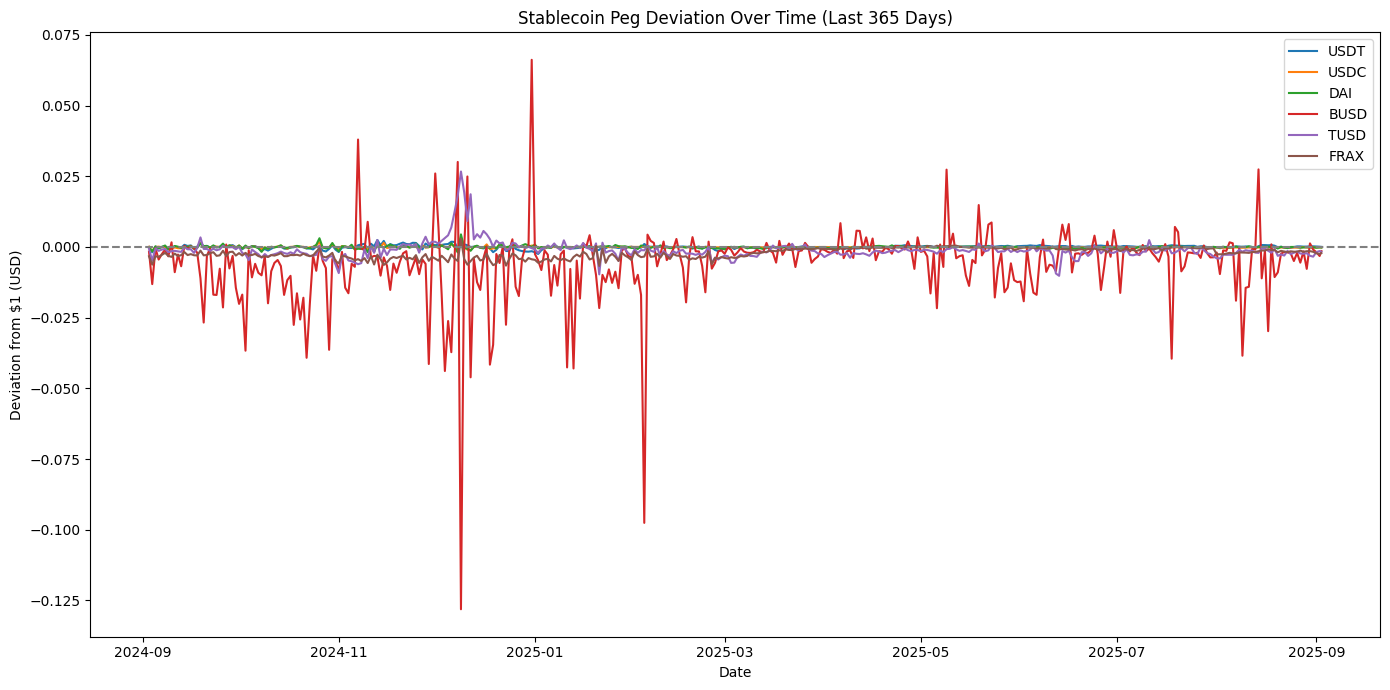

In [20]:
# using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for symbol, df_hist in historical_deviation_data.items():
    if not df_hist.empty:
        plt.plot(df_hist["date"], df_hist["peg_deviation (USD)"], label=symbol.upper())

plt.axhline(0, color="gray", linestyle="--")
plt.title("Stablecoin Peg Deviation Over Time (Last 365 Days)")
plt.xlabel("Date")
plt.ylabel("Deviation from $1 (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# using plotly for interactive visualization and log scale for y-axis

import plotly.graph_objs as go
import plotly.offline as pyoff

# Create interactive chart with log scale for y-axis
fig = go.Figure()

for symbol, df_hist in historical_deviation_data.items():
    if not df_hist.empty:
        fig.add_trace(go.Scatter(
            x=df_hist["date"],
            y=df_hist["peg_deviation (USD)"].abs() + 1e-8,  # add small value to avoid log(0)
            mode='lines',
            name=symbol.upper()
        ))

fig.update_layout(
    title="Stablecoin Peg Deviation Over Time (Last 365 Days) [Log Scale]",
    xaxis_title="Date",
    yaxis_title="Deviation from $1 (log scale, abs)",
    yaxis_type="log",
    legend_title="Stablecoin",
    template="plotly_white",
    height=600,
    width=1000
)

pyoff.iplot(fig)

### 4. Getting onchain mint / burn data from my Dune query - https://dune.com/queries/5719194

In [23]:
import os
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

dune_api_key = os.getenv("DUNE_API_KEY")

from dune_client.client import DuneClient
dune = DuneClient(dune_api_key)
query_result = dune.get_latest_result(5719194)

print(query_result.result)

ExecutionResult(rows=[{'BUSD burns': 0, 'BUSD mints': 0, 'BUSD supply': 55026240.2059419, 'DAI burns': -1013288075.723995, 'DAI mints': 1056715469.1322833, 'DAI supply': 4615325447.125135, 'FRAX burns': 0, 'FRAX mints': 0, 'FRAX supply': 296926532.5068286, 'LUSD burns': -343830.0320351251, 'LUSD mints': 53322.5731869419, 'LUSD supply': 38123526.77169894, 'PYUSD burns': -9190565.734848, 'PYUSD mints': 14777130.593745, 'PYUSD supply': 928019833.0413319, 'RLUSD burns': 0, 'RLUSD mints': 0, 'RLUSD supply': 616045484.55, 'USDC burns': -662264702.9240241, 'USDC mints': 701665808.8851131, 'USDC supply': 47162302241.040794, 'USDS burns': -364422012.65559036, 'USDS mints': 472312828.3250365, 'USDS supply': 4333691531.468174, 'sUSD burns': 0, 'sUSD mints': 1132499.493895871, 'sUSD supply': 41172237.58933132, 'week': '2025-09-01 00:00:00.000 UTC'}, {'BUSD burns': 0, 'BUSD mints': 0, 'BUSD supply': 55026240.2059419, 'DAI burns': -4275120242.6837163, 'DAI mints': 4488411162.875096, 'DAI supply': 45

In [24]:
import pandas as pd

rows = query_result.result.rows

df = pd.DataFrame(rows)

df.shape

(365, 28)

In [25]:
df.head()

,BUSD burns,BUSD mints,BUSD supply,DAI burns,DAI mints,DAI supply,FRAX burns,FRAX mints,FRAX supply,LUSD burns,...,USDC burns,USDC mints,USDC supply,USDS burns,USDS mints,USDS supply,sUSD burns,sUSD mints,sUSD supply,week
0,0.0,0.0,5.502624e+07,-1.013288e+09,1.056715e+09,4.615325e+09,0.000000e+00,0.0,2.969265e+08,-343830.032035,...,-6.622647e+08,7.016658e+08,4.716230e+10,-3.644220e+08,4.723128e+08,4.333692e+09,0.000000e+00,1.132499e+06,4.117224e+07,2025-09-01 00:00:00.000 UTC
1,0.0,0.0,5.502624e+07,-4.275120e+09,4.488411e+09,4.571898e+09,0.000000e+00,0.0,2.969265e+08,-479866.754522,...,-3.130862e+09,6.217926e+09,4.712290e+10,-2.862123e+09,2.923418e+09,4.225801e+09,-4.300000e+05,1.217965e+06,4.003974e+07,2025-08-25 00:00:00.000 UTC
2,0.0,0.0,5.502624e+07,-5.401021e+09,5.651767e+09,4.358607e+09,-4.119302e+04,0.0,2.969265e+08,-669031.325992,...,-3.956974e+09,2.929476e+09,4.403584e+10,-3.293347e+09,2.968563e+09,4.164507e+09,-1.801582e+05,2.501694e+06,3.925177e+07,2025-08-18 00:00:00.000 UTC
3,0.0,0.0,5.502624e+07,-6.077834e+09,6.361997e+09,4.107861e+09,-1.664812e+06,0.0,2.969677e+08,-620182.602544,...,-3.850290e+09,6.418029e+09,4.506333e+10,-4.841229e+09,4.518181e+09,4.489290e+09,-1.141180e+06,5.819456e+05,3.693024e+07,2025-08-11 00:00:00.000 UTC
4,0.0,0.0,5.502624e+07,-6.398433e+09,6.476942e+09,3.823699e+09,0.000000e+00,0.0,2.986325e+08,-875676.476450,...,-2.840476e+09,3.408760e+09,4.249560e+10,-2.568139e+09,2.896373e+09,4.812337e+09,-2.104048e+10,2.104115e+10,3.748947e+07,2025-08-04 00:00:00.000 UTC


In [26]:
df['week'] = pd.to_datetime(df['week'])
df_week = df.set_index('week')


df_week.head()

,BUSD burns,BUSD mints,BUSD supply,DAI burns,DAI mints,DAI supply,FRAX burns,FRAX mints,FRAX supply,LUSD burns,...,RLUSD supply,USDC burns,USDC mints,USDC supply,USDS burns,USDS mints,USDS supply,sUSD burns,sUSD mints,sUSD supply
week,,,,,,,,,,,,,,,,,,,,,
2025-09-01 00:00:00+00:00,0.0,0.0,5.502624e+07,-1.013288e+09,1.056715e+09,4.615325e+09,0.000000e+00,0.0,2.969265e+08,-343830.032035,...,6.160455e+08,-6.622647e+08,7.016658e+08,4.716230e+10,-3.644220e+08,4.723128e+08,4.333692e+09,0.000000e+00,1.132499e+06,4.117224e+07
2025-08-25 00:00:00+00:00,0.0,0.0,5.502624e+07,-4.275120e+09,4.488411e+09,4.571898e+09,0.000000e+00,0.0,2.969265e+08,-479866.754522,...,6.160455e+08,-3.130862e+09,6.217926e+09,4.712290e+10,-2.862123e+09,2.923418e+09,4.225801e+09,-4.300000e+05,1.217965e+06,4.003974e+07
2025-08-18 00:00:00+00:00,0.0,0.0,5.502624e+07,-5.401021e+09,5.651767e+09,4.358607e+09,-4.119302e+04,0.0,2.969265e+08,-669031.325992,...,6.008379e+08,-3.956974e+09,2.929476e+09,4.403584e+10,-3.293347e+09,2.968563e+09,4.164507e+09,-1.801582e+05,2.501694e+06,3.925177e+07
2025-08-11 00:00:00+00:00,0.0,0.0,5.502624e+07,-6.077834e+09,6.361997e+09,4.107861e+09,-1.664812e+06,0.0,2.969677e+08,-620182.602544,...,5.808381e+08,-3.850290e+09,6.418029e+09,4.506333e+10,-4.841229e+09,4.518181e+09,4.489290e+09,-1.141180e+06,5.819456e+05,3.693024e+07
2025-08-04 00:00:00+00:00,0.0,0.0,5.502624e+07,-6.398433e+09,6.476942e+09,3.823699e+09,0.000000e+00,0.0,2.986325e+08,-875676.476450,...,5.768381e+08,-2.840476e+09,3.408760e+09,4.249560e+10,-2.568139e+09,2.896373e+09,4.812337e+09,-2.104048e+10,2.104115e+10,3.748947e+07


In [27]:
supply_df = df[['week', 'USDC supply', 'DAI supply', 'LUSD supply', 'sUSD supply', 'PYUSD supply', 'RLUSD supply', 'USDS supply', 'BUSD supply', 'FRAX supply']]

supply_df.head()

,week,USDC supply,DAI supply,LUSD supply,sUSD supply,PYUSD supply,RLUSD supply,USDS supply,BUSD supply,FRAX supply
0,2025-09-01 00:00:00+00:00,4.716230e+10,4.615325e+09,3.812353e+07,4.117224e+07,9.280198e+08,6.160455e+08,4.333692e+09,5.502624e+07,2.969265e+08
1,2025-08-25 00:00:00+00:00,4.712290e+10,4.571898e+09,3.841403e+07,4.003974e+07,9.224333e+08,6.160455e+08,4.225801e+09,5.502624e+07,2.969265e+08
2,2025-08-18 00:00:00+00:00,4.403584e+10,4.358607e+09,3.865370e+07,3.925177e+07,9.314137e+08,6.008379e+08,4.164507e+09,5.502624e+07,2.969265e+08
3,2025-08-11 00:00:00+00:00,4.506333e+10,4.107861e+09,3.928036e+07,3.693024e+07,9.280479e+08,5.808381e+08,4.489290e+09,5.502624e+07,2.969677e+08
4,2025-08-04 00:00:00+00:00,4.249560e+10,3.823699e+09,3.963112e+07,3.748947e+07,7.883588e+08,5.768381e+08,4.812337e+09,5.502624e+07,2.986325e+08


In [28]:
current_week_supply = supply_df.loc[0]

current_week_supply

week            2025-09-01 00:00:00+00:00
USDC supply            47162302241.040794
DAI supply              4615325447.125135
LUSD supply               38123526.771699
sUSD supply               41172237.589331
PYUSD supply             928019833.041332
RLUSD supply                 616045484.55
USDS supply             4333691531.468174
BUSD supply               55026240.205942
FRAX supply              296926532.506829
Name: 0, dtype: object

In [29]:
current_supply = current_week_supply[1:]

current_supply

USDC supply     47162302241.040794
DAI supply       4615325447.125135
LUSD supply        38123526.771699
sUSD supply        41172237.589331
PYUSD supply      928019833.041332
RLUSD supply          616045484.55
USDS supply      4333691531.468174
BUSD supply        55026240.205942
FRAX supply       296926532.506829
Name: 0, dtype: object

<Axes: title={'center': 'Current Stablecoin Supply (in billions)'}, xlabel='Stablecoin', ylabel='Supply (in billions)'>

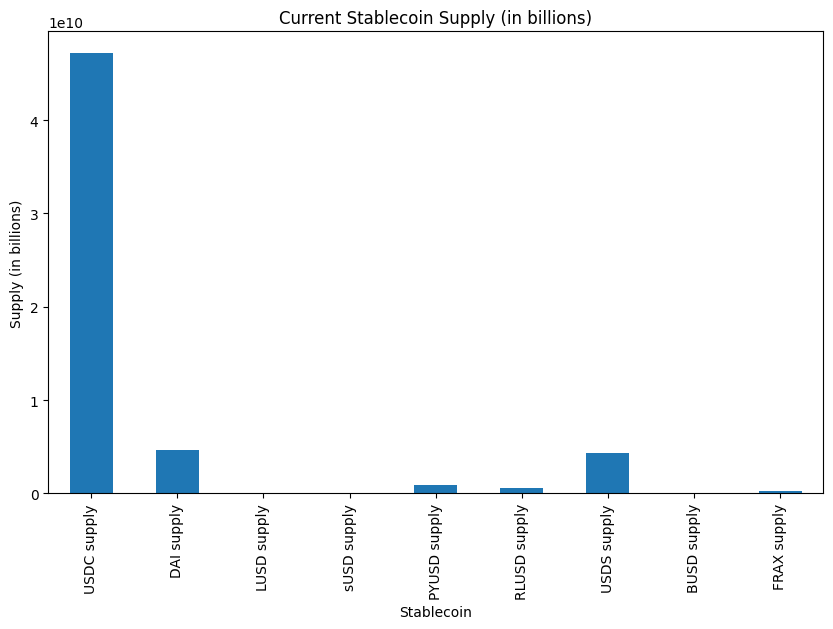

In [31]:
current_supply.plot(kind='bar', title='Current Stablecoin Supply (in billions)', figsize=(10, 6), ylabel='Supply (in billions)', xlabel='Stablecoin', legend=False)